In [84]:
# pip install pandas scikit-learn matplotlib tf_keras keras seaborn

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [86]:
df = pd.read_csv("/Users/gorazdfilipovski/PycharmProjects/VNP/AUD/aud11/emotions-dataset.csv")
df

,message,emotion
0,i used to be able to hang around talk with the...,anger
1,i get made to feel left out and unimportant in...,sadness
2,i wasnt going to post today as i am feeling qu...,sadness
3,i feel extremely delicate and a bit helpless,love
4,i feel frightened that i might fail to notice ...,fear
...,...,...
11995,i feel useless for wasting k hours k just for ...,sadness
11996,i feel rushed and pulled and rung out and i kn...,anger
11997,i feel absolutely disgusted,anger
11998,i know that we are all sinners and fall short ...,sadness


Check if the dataset is balanced.

<Axes: xlabel='emotion'>

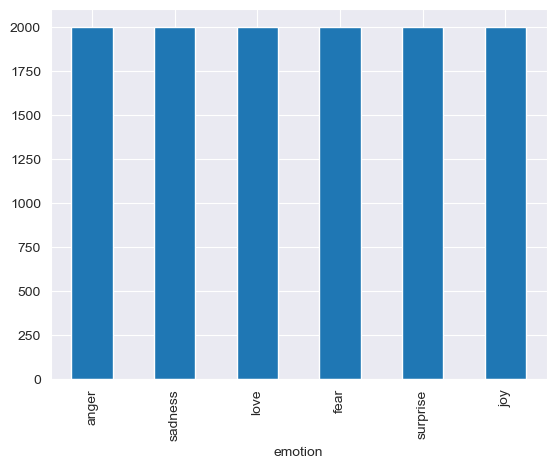

In [87]:
df["emotion"].value_counts().plot.bar()

Check if there are missing values.

In [88]:
df.isnull().sum()

message    0
emotion    0
dtype: int64

Plot the distribution of words per text.

In [89]:
df.sample(3)

,message,emotion
3848,i had a feeling the whales knew where we were ...,sadness
7311,i really really wanted to feel like i was doin...,love
312,i already have done all i want to do and have ...,joy


<Axes: ylabel='Frequency'>

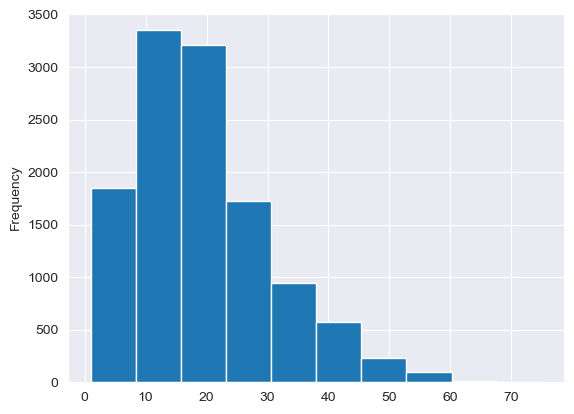

In [90]:
df["message"].str.split(" ").apply(len).plot.hist()

<Axes: >

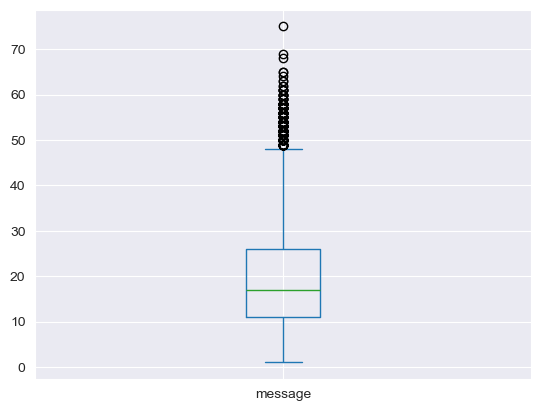

In [91]:
df["message"].str.split().apply(len).plot.box()

In [92]:
df = df[df["message"].str.split().apply(len) < 45].copy(deep=True)
df

,message,emotion
0,i used to be able to hang around talk with the...,anger
1,i get made to feel left out and unimportant in...,sadness
3,i feel extremely delicate and a bit helpless,love
4,i feel frightened that i might fail to notice ...,fear
5,i feel stubborn because i just want my seattle...,anger
...,...,...
11995,i feel useless for wasting k hours k just for ...,sadness
11996,i feel rushed and pulled and rung out and i kn...,anger
11997,i feel absolutely disgusted,anger
11998,i know that we are all sinners and fall short ...,sadness


<Axes: ylabel='Frequency'>

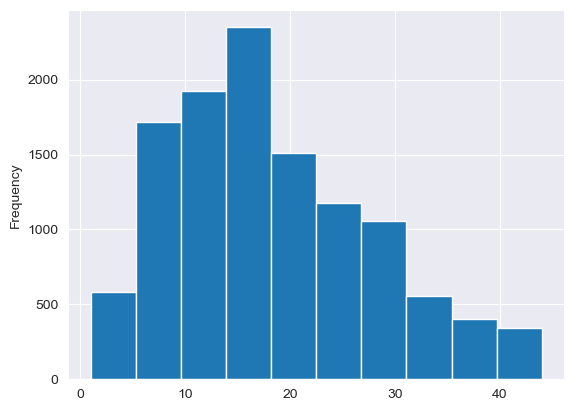

In [93]:
df["message"].str.split().apply(len).plot.hist()

<Axes: >

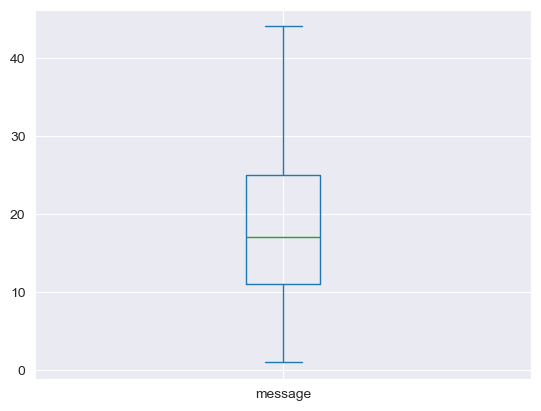

In [94]:
df["message"].str.split().apply(len).plot.box()

In [95]:
def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = []
    for text in texts:
        for word in text.split(" "):
            vocabulary.append(word)
    return list(set(vocabulary))

In [96]:
vocabulary = get_vocabulary(df["message"].tolist())

In [97]:
len(vocabulary)

12665

In [98]:
max_vocabulary_size = 10000

In [99]:
X, y = df["message"], pd.get_dummies(df["emotion"])

In [100]:
y.head()

,anger,fear,joy,love,sadness,surprise
0,True,False,False,False,False,False
1,False,False,False,False,True,False
3,False,False,False,True,False,False
4,False,True,False,False,False,False
5,True,False,False,False,False,False


In [101]:
num_classes = y.shape[1]
num_classes

6

In [102]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [103]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(train_X.values)
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

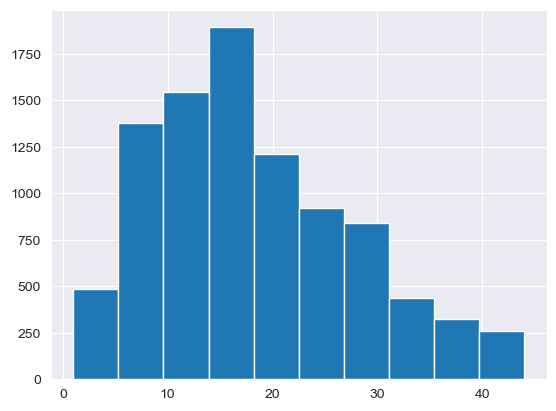

In [104]:
plt.hist([len(tokens) for tokens in train_X]);

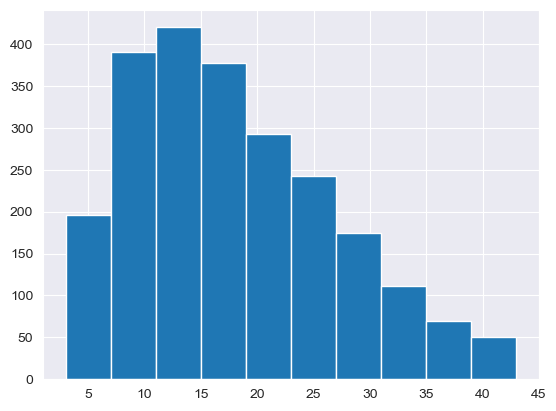

In [105]:
plt.hist([len(tokens) for tokens in test_X]);

In [106]:
maxlen = 32

In [107]:
# from tf_keras.preprocessing import sequence


In [110]:
# from tf_keras.preprocessing import sequence

train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [111]:
train_X.shape, test_X.shape

((9285, 32), (2322, 32))

In [112]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=128),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(num_classes, activation="softmax")
])

In [117]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)  # Round predictions to 0 or 1
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)  # Return mean F1 score across all classes

In [118]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=[f1_score]
)

In [119]:
history = model.fit(train_X, train_y, validation_split=0.2, batch_size=64, epochs=3)

Epoch 1/3
117/117 [==============================] - 4s 21ms/step - loss: 1.6041 - f1_score: 0.0692 - val_loss: 1.2034 - val_f1_score: 0.2512
Epoch 2/3
117/117 [==============================] - 3s 22ms/step - loss: 0.9537 - f1_score: 0.4022 - val_loss: 0.7903 - val_f1_score: 0.6549
Epoch 3/3
117/117 [==============================] - 3s 23ms/step - loss: 0.5397 - f1_score: 0.7960 - val_loss: 0.6700 - val_f1_score: 0.7665


In [120]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 conv1d (Conv1D)             (None, None, 32)          16416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          8256      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, None, 128)         9

<Axes: >

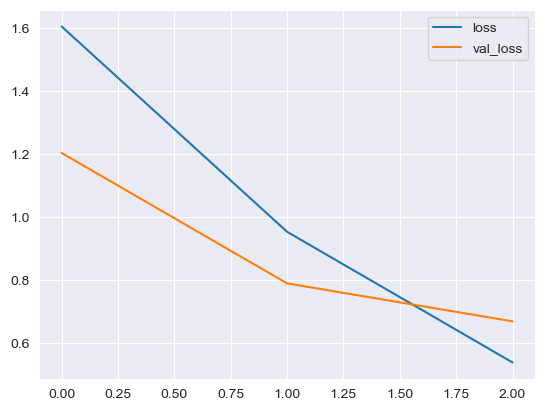

In [121]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [122]:
preds = model.predict(test_X)

73/73 [==============================] - 0s 2ms/step


In [123]:
test_y = test_y.values.argmax(axis=1)
preds = preds.argmax(axis=1)

In [124]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       389
           1       0.93      0.79      0.86       394
           2       0.69      0.73      0.71       396
           3       0.85      0.90      0.88       367
           4       0.64      0.70      0.67       397
           5       0.87      0.99      0.92       379

    accuracy                           0.79      2322
   macro avg       0.80      0.80      0.79      2322
weighted avg       0.80      0.79      0.79      2322



Text(0.5, 1.0, 'Confusion Matrix')

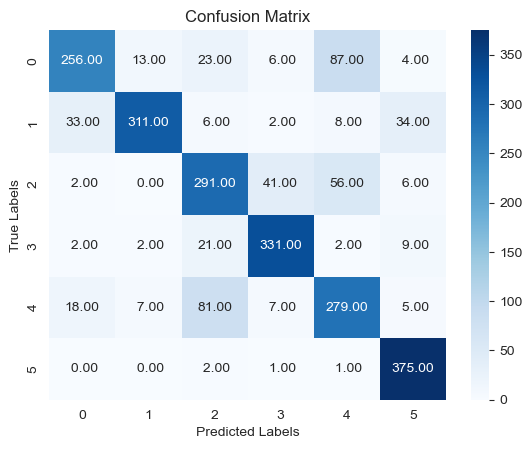

In [125]:
sns.heatmap(confusion_matrix(test_y, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [126]:
y.columns

Index(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], dtype='object')